In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
248919,r2q1k1r/pbppnpbp/1p2p1p1/8/PPPnP1P1/5N2/5P1P/R...,2
177780,8/5B1R/1p1R4/1p3k2/8/6p1/P6K/8 w - - 0 48,735
145587,r1b1k2r/ppppnppp/8/8/4qP2/8/P1PbB1PP/1R1QK2R w...,-593
202329,8/2Q3p1/p4pkp/3pq3/P1P5/1P4PP/5PK1/8 w - - 0 32,405
221614,2r2rk1/5p2/pnp3pp/5p2/2P5/1N2P1P1/P2q1P1P/2RR2...,458
...,...,...
206595,r2qk2r/ppp2ppp/2n2n2/3p1b2/4p3/3PPN2/PPPQBPPP/...,0
215384,8/5pk1/8/8/P7/1P4p1/3Q3b/3K4 w - - 0 42,502
323851,rnbqkb1r/pp2pp1p/3p1np1/2p5/8/1P4P1/PBPPPPBP/R...,61
217946,r2q1kr1/pp2pp1p/4b1p1/2p4n/4P3/5N2/PPPQBPPP/RN...,544


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.01
num_steps = 3000
warmup_steps = 250
bs = 128000*4
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
from torch.optim.lr_scheduler import SequentialLR, LambdaLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [14]:
model = MLPEngine(embedding_dim=32).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr = lr)
# scheduler = CosineAnnealingLR(optimiser, T_max=1000, eta_min=0.01)
warmup_scheduler = LambdaLR(optimiser, lr_lambda=lambda epoch: epoch / warmup_steps) # Warm-up steps
cosine_scheduler = CosineAnnealingLR(optimiser, T_max=1000, eta_min=1e-3)

scheduler = SequentialLR(optimiser, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])
model = model.to(torch.bfloat16)
model.compile()

In [15]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
train_history = {}
val_history = {}

In [ ]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[step_i] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(step_i, ': ',loss.item())

    if step_i % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[step_i] = loss.item()

0 :  34048.0
1 :  35328.0
2 :  31872.0
3 :  32768.0
4 :  33024.0
5 :  30976.0
6 :  33024.0
7 :  33024.0
8 :  33024.0
9 :  32128.0
10 :  31872.0
11 :  32128.0
12 :  33792.0
13 :  32128.0
14 :  34560.0
15 :  33280.0
16 :  35328.0
17 :  34304.0
18 :  31872.0
19 :  33024.0
20 :  33536.0
21 :  33280.0
22 :  31744.0
23 :  32384.0
24 :  31488.0
25 :  36352.0
26 :  35840.0
27 :  32000.0
28 :  32128.0
29 :  30464.0
30 :  32384.0
31 :  34560.0
32 :  32512.0
33 :  34048.0
34 :  33792.0
35 :  35840.0
36 :  33792.0
37 :  34048.0
38 :  33536.0
39 :  35072.0
40 :  34560.0
41 :  34816.0
42 :  31616.0
43 :  33792.0
44 :  30336.0
45 :  33024.0
46 :  33792.0
47 :  33536.0
48 :  33536.0
49 :  30848.0
50 :  32384.0
51 :  33024.0
52 :  33536.0
53 :  35072.0
54 :  33536.0
55 :  34560.0
56 :  33024.0
57 :  33024.0
58 :  33024.0
59 :  32640.0
60 :  34560.0
61 :  33024.0
62 :  33792.0
63 :  34816.0
64 :  33792.0
65 :  32384.0
66 :  31616.0
67 :  34304.0
68 :  33792.0
69 :  33024.0
70 :  31488.0
71 :  33792.0
72

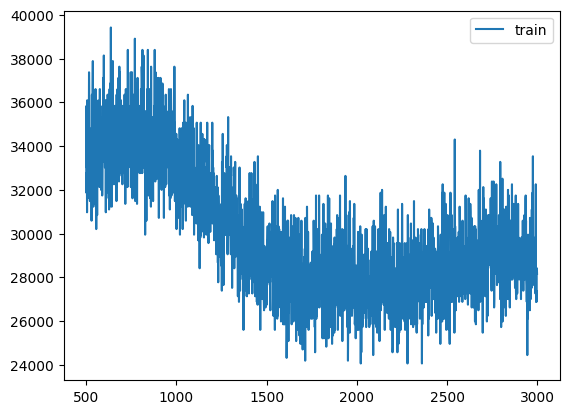

In [30]:
plt.plot(list(train_history.keys())[500:], list(train_history.values())[500:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

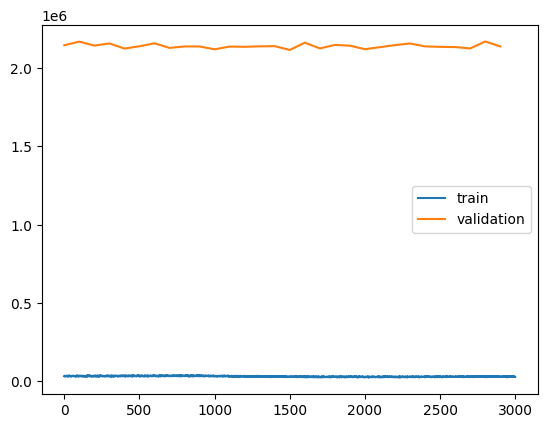

In [31]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [18]:
'''

At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k
'''

'\n\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n'

# Inference

In [19]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [20]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [21]:
get_score(fen_sample)

-0.07491955161094666

In [22]:
32*70

2240

# TODO
- [x] do inference
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add proper initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [ ] **learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [ ] **batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding

current precision is giving loss as int, fix it